In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [27]:
def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

# Leitura dos dados tratados

In [28]:
def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

In [29]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)

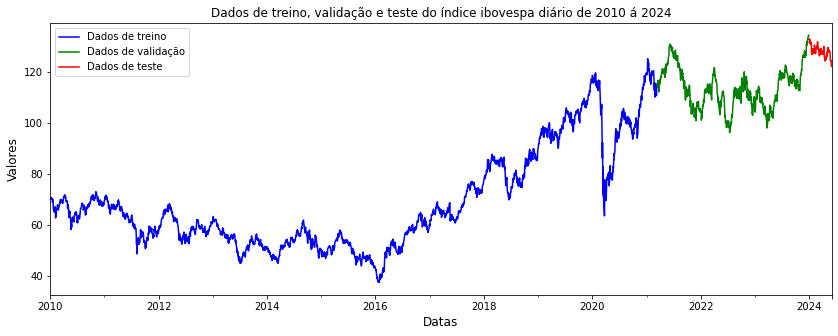

In [30]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
treino.plot(kind='line', x='data', y='valor', color='blue', label='Dados de treino', ax=ax)
teste.plot(kind='line', x='data', y='valor', color='green', label='Dados de validação', ax=ax)
previsao.plot(kind='line', x='data', y='valor', color='red', label='Dados de teste', ax=ax)
plt.title('Dados de treino, validação e teste do índice ibovespa diário de 2010 á 2024')
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.show()

In [31]:
teste

,data,valor
data,,
2021-03-15,2021-03-15,114.85074
2021-03-16,2021-03-16,114.01878
2021-03-17,2021-03-17,116.54944
2021-03-18,2021-03-18,114.83543
2021-03-19,2021-03-19,116.22158
...,...,...
2023-12-26,2023-12-26,133.53292
2023-12-27,2023-12-27,134.19372
2023-12-28,2023-12-28,134.18524


In [32]:
treino.set_index('data', inplace=True)
treino.index = pd.DatetimeIndex(treino.index.values, freq='D')
teste.set_index('data', inplace=True)
teste.index = pd.DatetimeIndex(teste.index.values, freq='D')
previsao.set_index('data', inplace=True)
previsao.index = pd.DatetimeIndex(previsao.index.values, freq='D')

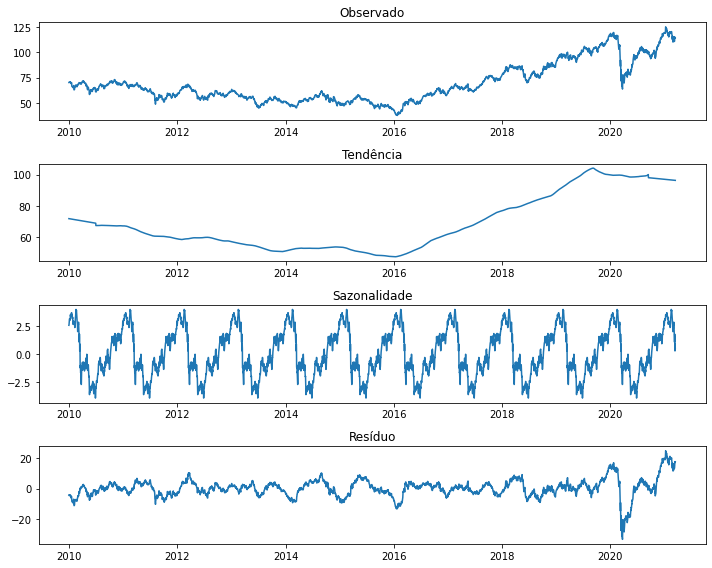

In [33]:

result = seasonal_decompose(treino, model='additive',period=365,extrapolate_trend='freq')
# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))

# Você pode alterar os rótulos aqui
ax1.set_title('Observado')
ax1.plot(result.observed)

ax2.set_title('Tendência')
ax2.plot(result.trend)

ax3.set_title('Sazonalidade')
ax3.plot(result.seasonal)

ax4.set_title('Resíduo')
ax4.plot(result.resid)

plt.tight_layout()
plt.show()

# Verificando estacionariedade

In [34]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [35]:
# Componente sasonal
seasonal = result.seasonal
check_stationarity(seasonal)

# série temporal
check_stationarity(treino)

# A componente sazonal é estacionária, mas a série não. Será preciso realizar a diferenciação

The series is stationary
The series is NOT stationary


# Gráficos de pacf e acf

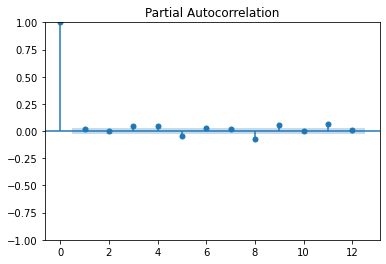

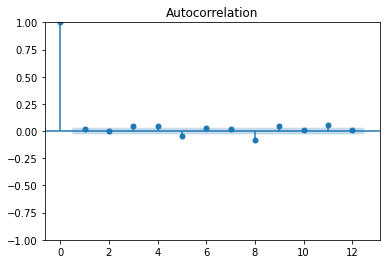

In [406]:

plot_pacf(treino.diff().dropna(), lags =12)
plt.show()
plot_acf(treino.diff().dropna(), lags =12)
plt.show()

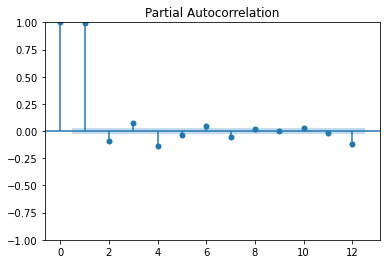

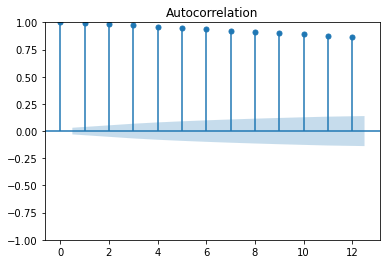

In [407]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal.dropna(), lags =12)
plt.show()
plot_acf(seasonal.dropna(), lags =12)
plt.show()

# Parâmetros obtidos nos gráficos

In [408]:
# Analisando os gráficos pode ser visto que uma possível configuração pode ser pdq = 1,1,1 e PDQ = 0,0,1¶
ACF_PACF_config = [(1,1,1),(2,0,0, 12),'n']

# Parmâmetros obtidos com auto arima

In [409]:
# Suponha que 'data' seja a sua série temporal
auto_arima_config = auto_arima(treino, seasonal=True, m=12)  # m é o período da sazonalidade

In [410]:
# Obter os parâmetros 'order' e 'seasonal_order'

order = auto_arima_config.order
seasonal_order = auto_arima_config.seasonal_order
auto_arima_config = [order,seasonal_order,'n']
auto_arima_config

[(0, 1, 0), (0, 0, 0, 12), 'n']

# Parâmetros com grid search

In [12]:
def sarima_parameter_search(inicio,search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = d = range(inicio, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio=0, search_range = 2)

In [48]:
def seasonal_arima_model(df_teste, time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(df_teste, prediction))
            mae = mean_absolute_error(df_teste, prediction)
            mape = mean_absolute_percentage_error(df_teste, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(df_teste, prediction))
            mae = mean_absolute_error(df_teste, prediction)
            mape = mean_absolute_percentage_error(df_teste, prediction)
            
            return rmse,mae,mape, model_fit, prediction
    except Exception as e:
        print(f"Could not fit with the designated model parameters: {e}")
        return None, None, None, None, None


def seasonal_arima_model_arima(df_teste,time_series=None, order=None, steps=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        model = ARIMA(time_series, order=order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=steps)
        rmse = np.sqrt(mean_squared_error(df_teste, prediction))

        return rmse, model_fit, prediction
    except Exception as e:
        print(f"Could not fit with the designated model parameters: {e}")
        return None, None, None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps,df_teste, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        df_teste = df_teste,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            df_teste = df_teste,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo
                    predicao = prediction

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf, predicao

In [413]:
rmse,mae,mape,model, grid_search_melhor_conf,predicao = grid_search(order_combos,seasonal_order_combos, treino, len(teste), teste, "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")

order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 113.58616546167534 , mae-- 113.3133297208619 , mape-- 1.0
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 45.21796750499517 , mae-- 44.528174153276 , mape-- 0.3900562179678821
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 19.24751690418805 , mae-- 17.273970380203355 , mape-- 0.15644225784940952
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 18.667279850238394 , mae-- 16.551754601492856 , mape-- 0.1418977468004876
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 113.05853039064647 , mae-- 112.60321913454047 , mape-- 0.9938126687093759
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 44.98964347966033 , mae-- 44.2293410579495 , mape-- 0.3874481194614259
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 19.269764577374993 , mae-- 17.30832735428839 , mape-- 0.15675006933855565
order--  (0, 0, 0) , seasonal order

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 30.92321370408764 , mae-- 27.306453712647116 , mape-- 0.2454583017967096
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.101163466902191 , mae-- 6.545557073668925 , mape-- 0.05785849759142827
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 10.530001650900656 , mae-- 8.977100272524899 , mape-- 0.08160247862865805
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 22.724523351164503 , mae-- 20.285282153394654 , mape-- 0.18297448935034163
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 31.038771582448582 , mae-- 27.391358778112906 , mape-- 0.24622917846667366


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 11.17318269636988 , mae-- 9.642453169990391 , mape-- 0.08769288310307413
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 8.889341410248186 , mae-- 7.036394783287608 , mape-- 0.060507983940946655
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 21.182296439489296 , mae-- 19.00053063614804 , mape-- 0.17159110829769603
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 29.29586550364794 , mae-- 28.174584521135674 , mape-- 0.24503259583994558
order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 10.338789924036208 , mae-- 8.777497528299019 , mape-- 0.0797474006912023


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 13.1769900027877 , mae-- 10.6150533740757 , mape-- 0.09051642791534395


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 21.177802147268302 , mae-- 18.99490693989828 , mape-- 0.17156395318475695


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 54531.16377022733 , mae-- 26932.21865307133 , mape-- 227.6162068601542
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.115862538700044 , mae-- 6.5546275825197675 , mape-- 0.05788614756387137
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 10.427740058327903 , mae-- 8.870979874066101 , mape-- 0.08060246715599677
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 21.343774929954716 , mae-- 19.076355058354796 , mape-- 0.17216074313408458
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 30.98545688821619 , mae-- 27.337252206987895 , mape-- 0.2456994473045673
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.12436987215948 , mae-- 6.5580823776009565 , mape-- 0.0578639611553721
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 10.457330771052415 , mae-- 8.899035172121607 , mape-- 0.08084259085935565
order--  (0, 0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 37.83733299989831 , mae-- 33.159371240275036 , mape-- 0.29766605180633904
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 9.98832869405966 , mae-- 8.470963564134916 , mape-- 0.07692335664842566
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 13.056479210256237 , mae-- 10.527575192203077 , mape-- 0.08972501734165822


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 16.035321457107678 , mae-- 14.334254208939171 , mape-- 0.1297962111601696


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 29.606220763537856 , mae-- 28.49767871612917 , mape-- 0.24790380975371182


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 10.221433823759643 , mae-- 8.71288748103654 , mape-- 0.07916321422415667


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 16.706712244748232 , mae-- 13.895162347511203 , mape-- 0.11918191695861031
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 21.591624499051285 , mae-- 19.38064275414779 , mape-- 0.17530752276699654


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 27.043202330392997 , mae-- 25.759929536719905 , mape-- 0.22364298048338294
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.988707750612013 , mae-- 6.452819435359384 , mape-- 0.05699137494754466
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 10.308572967483943 , mae-- 8.805699917558494 , mape-- 0.08002797429594533
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 21.53332701652873 , mae-- 19.247257875123054 , mape-- 0.17369752406189534


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 30.434830552783552 , mae-- 26.87685042333801 , mape-- 0.24161467543958098
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 7.989916510482115 , mae-- 6.45405608560421 , mape-- 0.05700467379431764
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 10.411493779364877 , mae-- 8.907988963247979 , mape-- 0.08097286309358145
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 21.631193115746328 , mae-- 19.32905056806061 , mape-- 0.17443170612869768
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 30.502850040398236 , mae-- 26.932657812764518 , mape-- 0.2421165861916048
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913521334786574 , mae-- 6.433117405484818 , mape-- 0.05733066633653761
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 10.711451210763293 , mae-- 9.234247604298277 , mape-- 0.08415915859642079


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.657711855960944 , mae-- 21.134234631828406 , mape-- 0.19069740386615772


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 32.11867285765295 , mae-- 28.333044183094145 , mape-- 0.2547637246132644
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.916260861882343 , mae-- 6.436191948815474 , mape-- 0.05737017488665293
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 10.76035394205638 , mae-- 9.280550141848192 , mape-- 0.08458911819125586
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 23.669146702899408 , mae-- 21.144070705911005 , mape-- 0.1907877291559238
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 32.129648633140086 , mae-- 28.34251146183184 , mape-- 0.254850457512342
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 130.09557077989768 , mae-- 112.58712767865362 , mape-- 1.0048760889058128
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 143.23959947756217 , mae-- 122.78170327183483 , mape-- 1.0945972850795527


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 167.67521231406187 , mae-- 141.45147483278214 , mape-- 1.2587532018895795
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 184.4753748292524 , mae-- 154.12995191692625 , mape-- 1.3701538260388122
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 10.905987713936446 , mae-- 9.419381897143976 , mape-- 0.08586076960010273
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 31.53029119697382 , mae-- 27.835649448764876 , mape-- 0.25033160707664537


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 72.35773575138467 , mae-- 56.11588279935777 , mape-- 0.49047779094959143


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 54.0559786798684 , mae-- 42.40693424637929 , mape-- 0.36992891410761697
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.916197127768202 , mae-- 6.436122214095494 , mape-- 0.057369273436059666
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 10.704178453039743 , mae-- 9.226868778888631 , mape-- 0.08409477667093722


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 23.68192442696013 , mae-- 21.155118412467342 , mape-- 0.19088748712598597


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 32.22189989052856 , mae-- 28.420305061735124 , mape-- 0.255543944423881
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.915325166952655 , mae-- 6.43515977507727 , mape-- 0.05735684576882774
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.816561219833375 , mae-- 9.334360957676687 , mape-- 0.0850829554416535


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 23.058758177684325 , mae-- 20.6134058393418 , mape-- 0.18605511625851415


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 32.66127336313923 , mae-- 28.785610920171827 , mape-- 0.258784158401508
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 39.93989952679925 , mae-- 34.27177473704007 , mape-- 0.2996318597660771
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 29.598936936909606 , mae-- 26.185085728831922 , mape-- 0.2284544863947358


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 75.68350165615446 , mae-- 61.33050483532927 , mape-- 0.537652911785595


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 64.19798012250978 , mae-- 52.775202683098605 , mape-- 0.4624730221954547
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 10.90274648036598 , mae-- 9.416310939548872 , mape-- 0.0858325250451516
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 31.58437857302943 , mae-- 27.881363577862224 , mape-- 0.25073871289915006


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 80.18395594071148 , mae-- 63.24186627687824 , mape-- 0.5538237297462631


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 62.7755228298997 , mae-- 50.222759021241274 , mape-- 0.4393541657963297
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913520808532497 , mae-- 6.433116832466809 , mape-- 0.057330658848140634
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 10.712183455014301 , mae-- 9.234952064310528 , mape-- 0.08416561565672392


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.340290672333897 , mae-- 20.85846420291097 , mape-- 0.1882384090113037


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 31.673062512466352 , mae-- 27.956059375437388 , mape-- 0.2514050834571878
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.9158638529236045 , mae-- 6.435745107177933 , mape-- 0.057364459409412275
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 10.840951344300171 , mae-- 9.35741885606024 , mape-- 0.08529595659544635


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 23.35163202596004 , mae-- 20.86823598655893 , mape-- 0.18832814365235426


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 31.683963257002198 , mae-- 27.965444400893222 , mape-- 0.2514910859033746
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 131.2143187502529 , mae-- 113.56007817502845 , mape-- 1.0135188262795254
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 148.355212976657 , mae-- 126.84065782195734 , mape-- 1.1303995707639092
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 168.94328588077667 , mae-- 142.5366807843317 , mape-- 1.2683821011538656
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 171.34111336136849 , mae-- 144.35053897613915 , mape-- 1.2843197736162395
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 10.712787308851947 , mae-- 9.235491336893933 , mape-- 0.08416824883837702
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 31.549347696483288 , mae-- 27.851760627112057 , mape-- 0.2504748908302091


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 71.62574776541862 , mae-- 55.56703188727594 , mape-- 0.4856488422477488


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 69.0053574420005 , mae-- 53.60688733543195 , mape-- 0.46841239015895325
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.915820559934345 , mae-- 6.435697691104559 , mape-- 0.0573638457394089
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 10.701584440003556 , mae-- 9.224449959470402 , mape-- 0.08407197313502457


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 23.542600816499 , mae-- 21.034154466922846 , mape-- 0.18980878114915217


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 31.958573863037305 , mae-- 28.197900599304205 , mape-- 0.25356319011842854
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.915040290340178 , mae-- 6.4348376533581995 , mape-- 0.057352724638345225
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.893015620052026 , mae-- 9.40685297660179 , mape-- 0.08574967730126858


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 22.841015025061658 , mae-- 20.42377821552236 , mape-- 0.18436412689844794


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 32.29215290936589 , mae-- 28.473833285273983 , mape-- 0.2560070785821714
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 39.943353098728 , mae-- 34.27484199439162 , mape-- 0.29965910511707045
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 29.508838049646606 , mae-- 26.113730638986507 , mape-- 0.22782660112563763


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 75.21898577047887 , mae-- 60.97882377767947 , mape-- 0.534557743887484
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 73.57433613982496 , mae-- 59.75560600174989 , mape-- 0.5238086744271964
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 10.745492168184082 , mae-- 9.266850796893557 , mape-- 0.0844568999565074
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 34.88195313256611 , mae-- 30.660278020454832 , mape-- 0.27548488230061763


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 79.51139661074845 , mae-- 62.74054774731403 , mape-- 0.5494145780365743


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 77.01928377050568 , mae-- 60.8790463207471 , mape-- 0.5330474321937129
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 12.591484381821866 , mae-- 11.057202910837038 , mape-- 0.10072435471903211
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 7.878490972923113 , mae-- 6.397366918412379 , mape-- 0.056874782791611324


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 22.682088019727736 , mae-- 20.31560815881224 , mape-- 0.18350845326503973


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 11.356191129622575 , mae-- 9.862844396336023 , mape-- 0.0897520550968745


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 12.134802135502321 , mae-- 10.613538249043412 , mape-- 0.0967359410666897


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.80228193849395 , mae-- 23.488552092945774 , mape-- 0.20493110160018727


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 8.831755705058569 , mae-- 7.267710808651 , mape-- 0.06590090578379099
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 8.947625239285342 , mae-- 7.000563783630579 , mape-- 0.0602163098420387
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.393947749259556 , mae-- 6.848078762770486 , mape-- 0.06181742761274678
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 11.981294799877338 , mae-- 10.38221074961368 , mape-- 0.09487833061016775


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 25.612255597489963 , mae-- 22.826634106114202 , mape-- 0.20603827048989598


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 34.49647493749313 , mae-- 30.377310287427814 , mape-- 0.273201723052552
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 7.855862872564664 , mae-- 6.36660286487311 , mape-- 0.05646760847687618
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 11.199127585361918 , mae-- 9.708462938615916 , mape-- 0.0883467452813858
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 27.382485560277992 , mae-- 24.3876164816417 , mape-- 0.22026195172844432
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 36.32659512471258 , mae-- 32.01593515434602 , mape-- 0.2880864104112207
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 12.225145187446614 , mae-- 10.704640515942346 , mape-- 0.09754093160524646
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.851734767597968 , mae-- 6.343272642461798 , mape-- 0.056007601546777266
order--  (1, 0, 0)

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 10.876568491416611 , mae-- 9.195457973365635 , mape-- 0.07847543658554315
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.071810289443997 , mae-- 6.454189845367936 , mape-- 0.05627085773231686
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 9.788440943102897 , mae-- 8.282972108827392 , mape-- 0.07493787953657781


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 26.615466277334264 , mae-- 23.711720437134066 , mape-- 0.21418929772371978
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 36.88062373878078 , mae-- 32.4590369457966 , mape-- 0.29196615349769856
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 7.8562627600236565 , mae-- 6.367193792372836 , mape-- 0.05647620079468586
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 11.198265142423448 , mae-- 9.707613131345896 , mape-- 0.08833900706708049
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 26.933382191847755 , mae-- 23.995511096377367 , mape-- 0.21676361437693917


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 37.16133855954613 , mae-- 32.71426327543303 , mape-- 0.29428252525379617
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 12.456127440013093 , mae-- 10.927782678935273 , mape-- 0.0995545684881493
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 7.848851086535747 , mae-- 6.350575776951593 , mape-- 0.0561912381337197


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 22.573094076800615 , mae-- 20.219415522040382 , mape-- 0.1826478196625258


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 11.036535214815647 , mae-- 9.547239216227544 , mape-- 0.08687699929510823


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 14.967760707566326 , mae-- 13.313613896559309 , mape-- 0.12100725941215121


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.988062386466485 , mae-- 23.65317902255974 , mape-- 0.2063915617707997


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 16.240022724786552 , mae-- 14.509145084860046 , mape-- 0.13166874789032604


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 7.813973579745537 , mae-- 6.222390430630733 , mape-- 0.054117988574102174
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.355476298100472 , mae-- 6.812636294329821 , mape-- 0.06144567005873457
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 11.956763868596582 , mae-- 10.361898511999062 , mape-- 0.09467521006878749


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 25.207933354137463 , mae-- 22.475315618805393 , mape-- 0.20288771117345986
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 33.42284893892251 , mae-- 29.46684004097268 , mape-- 0.2650825852596031
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 7.8521681124082265 , mae-- 6.33791897783298 , mape-- 0.05591092861588084
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 10.894355874018784 , mae-- 9.406091088893461 , mape-- 0.08558703101376768
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 26.781200155295227 , mae-- 23.860027618533234 , mape-- 0.21553224727562295


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 34.988582624696235 , mae-- 30.871210821877526 , mape-- 0.27787374522816566
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 12.086736764220165 , mae-- 10.569977553065058 , mape-- 0.09632265532058418
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 8.084906305293586 , mae-- 6.435635560029649 , mape-- 0.056089046599656855


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 1362.931175274211 , mae-- 966.0272526570368 , mape-- 8.448171600972366


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 10.509263004735805 , mae-- 8.681931285979816 , mape-- 0.07378326848347426
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 13.043405024614593 , mae-- 11.485694060869337 , mape-- 0.10459628218509084
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.862649117023516 , mae-- 6.339600602595455 , mape-- 0.05585702134375579


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 12.445899472728112 , mae-- 10.80275069330971 , mape-- 0.09787300321280024


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 2926177.047748532 , mae-- 1127001.8947148658 , mape-- 9289.488859089182
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.062080209107798 , mae-- 6.448152430007873 , mape-- 0.056243668051750045
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 9.798940378045613 , mae-- 8.295986205801178 , mape-- 0.07506820726435656
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 26.21166166023683 , mae-- 23.355979391950367 , mape-- 0.2109907143965497


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 35.631452543264615 , mae-- 31.393364858288262 , mape-- 0.2824594714299112
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 7.852019051740554 , mae-- 6.3379246021272335 , mape-- 0.05591222810898653
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 10.865606903453509 , mae-- 9.37740165898783 , mape-- 0.08532574270230296


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 26.515718673832268 , mae-- 23.62706605710914 , mape-- 0.21345055295842388
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 35.90170333036548 , mae-- 31.638131188916738 , mape-- 0.2846815686941332
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913521334786574 , mae-- 6.433117405484818 , mape-- 0.05733066633653761
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 10.712865759142892 , mae-- 9.235604476831915 , mape-- 0.08417162380532414
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.667119353029133 , mae-- 21.142406771898223 , mape-- 0.19077016016446327
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 32.1307333779632 , mae-- 28.34325142971346 , mape-- 0.25485453483748655
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.915872317026306 , mae-- 6.435754661876524 , mape-- 0.05736458157339807
order--  (1, 1,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 23.678446445829294 , mae-- 21.152150352379238 , mape-- 0.19085963577029064
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 32.14652659786056 , mae-- 28.356802619947274 , mape-- 0.2549776443078483
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 131.16027773747152 , mae-- 113.51308212019582 , mape-- 1.013101362502741
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 144.5799928466045 , mae-- 123.9203913375745 , mape-- 1.1046948044921832
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 169.08839606934964 , mae-- 142.64324179458055 , mape-- 1.2693165043146435


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 179.42225376839923 , mae-- 150.44940938030572 , mape-- 1.3379062070515684
order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 10.70760219019368 , mae-- 9.230533145108414 , mape-- 0.08412258180514129
order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 31.51990792161933 , mae-- 27.82687324260414 , mape-- 0.2502532458223748


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 70.80183830633747 , mae-- 54.94364817091083 , mape-- 0.48016153185295346


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 59.53077060874281 , mae-- 46.504993477270766 , mape-- 0.40595662574364283
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.915821097104402 , mae-- 6.435698286576169 , mape-- 0.05736385340849174
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 10.762686944939068 , mae-- 9.282856705300272 , mape-- 0.0846097289354943
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 23.68771117857502 , mae-- 21.160149250463075 , mape-- 0.19093219699163977
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 32.22776371041706 , mae-- 28.425254871727375 , mape-- 0.2555878588801548
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.915036648917423 , mae-- 6.434833514665218 , mape-- 0.057352671764002765
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.819115196647834 , mae-- 9.336833805491658 , mape-- 0.08510530940687316


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 23.025429021256482 , mae-- 20.584402664917928 , mape-- 0.18579637295160306


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 32.63315216922562 , mae-- 28.76176703035083 , mape-- 0.2585714421926738
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 39.94043425701043 , mae-- 34.27224957550154 , mape-- 0.2996360775844992
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 29.87381244747124 , mae-- 26.403281775782204 , mape-- 0.230374964060605


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 74.68042770820779 , mae-- 60.57469859625413 , mape-- 0.5310030531017873


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 67.60715278424348 , mae-- 55.30854795482715 , mape-- 0.48472660706064075
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 10.71767867006403 , mae-- 9.240182797308147 , mape-- 0.08421143711860746
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 31.510591471880286 , mae-- 27.818998346715418 , mape-- 0.25018311592820913


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 78.72467575707415 , mae-- 62.14648549527551 , mape-- 0.5441859668777166


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 68.00437593723092 , mae-- 54.13247055969582 , mape-- 0.47372325466951687
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913157825042375 , mae-- 6.432722460123778 , mape-- 0.05732549704307646
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 10.720374755900613 , mae-- 9.242856231400385 , mape-- 0.08423787962383755
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 17.485224937002656 , mae-- 15.664201909538011 , mape-- 0.1419164963774033
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 22.86128628397188 , mae-- 20.421700269523715 , mape-- 0.18427720262202055
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.91542249044288 , mae-- 6.435258151834983 , mape-- 0.05735817105129391
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 10.844204916534212 , mae-- 9.360590069917565 , mape-- 0.08532451949628309
order--  (1, 1,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 101.99855574630865 , mae-- 78.51573614388296 , mape-- 0.6876551909052199


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 97.21048247202343 , mae-- 74.94308968888053 , mape-- 0.6562392646798615
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.913726012931193 , mae-- 6.433356264793371 , mape-- 0.057333701282961114
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 10.747169243715625 , mae-- 9.268370766276009 , mape-- 0.08447352865764869
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 16.21230492420144 , mae-- 14.490904282581802 , mape-- 0.13145605038861155
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 22.17522344546819 , mae-- 19.82372699673432 , mape-- 0.17894874356437868
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.914933352466794 , mae-- 6.43472285661458 , mape-- 0.05735122750903105
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.867616214368278 , mae-- 9.38288476510168 , mape-- 0.0855288316193474
order--  (1, 1, 1)

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 94.33526422959167 , mae-- 75.30679702526444 , mape-- 0.6605928629017632


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 91.32672960164936 , mae-- 73.07714302734108 , mape-- 0.6409996942062878
order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 10.921851536056494 , mae-- 9.432704981845239 , mape-- 0.08599851172853601
order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 31.153993780011113 , mae-- 27.51738827133413 , mape-- 0.24749678963692412


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 108.41311341635986 , mae-- 84.53758816225962 , mape-- 0.7412612508551851


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 103.85997401454188 , mae-- 81.14472085453788 , mape-- 0.7114296530737493
A melhor configuração para essa série temporal é:[(1, 0, 0), (1, 0, 1, 12), 't']
rmse:7.547711672066204
mae:6.054468087619766
mape:0.05400893140862353


# Selecionando os melhores parâmetros

In [17]:
configs = [ACF_PACF_config, auto_arima_config,grid_search_melhor_conf]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,mae_pred,mape_pred,model_fit,teste_pred = seasonal_arima_model(teste,treino, config[0], config[1], config[2],len(teste),"SARIMA")
    if rmse_pred <= rmse or mae_pred <= mae or mape_pred <= mape :
        melhor_model = model_fit
        mae=mae_pred
        mape = mape_pred 
        melhor_teste =  teste_pred
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}, mae:{mae}, mape:{mape}")

RMSE da config: [(1, 0, 0), (1, 0, 1, 12), 't']- rmse:7.547711672066204, mae:6.054468087619766, mape:0.05400893140862353
RMSE da config: [(1, 1, 0), (1, 0, 1, 12), 'n']- rmse:7.547711672066204, mae:6.054468087619766, mape:0.05400893140862353


# Utilizando o modelo para previsões futuras

In [418]:
treino_concat = pd.concat([treino, teste])
teste_concat = pd.concat([previsao])

In [416]:
treino_concat.index = pd.DatetimeIndex(treino_concat.index.values, freq='D')

In [438]:
rmse_pred,mae_pred,mape_pred,melhor_model,predicao_teste = seasonal_arima_model(teste,treino,grid_search_melhor_conf[0],grid_search_melhor_conf[1], grid_search_melhor_conf[2],len(teste),"SARIMA")

In [439]:
print(rmse_pred)
print(mae_pred)
print(mape_pred)

7.547711672066204
6.054468087619766
0.05400893140862353


In [440]:
rmse_pred,mae_pred,mape_pred,melhor_model,predicao_futura = seasonal_arima_model(teste_concat,treino_concat,grid_search_melhor_conf[0],grid_search_melhor_conf[1], grid_search_melhor_conf[2],len(teste_concat),"SARIMA")

In [441]:
print(rmse_pred)
print(mae_pred)
print(mape_pred)

11.301264293741825
10.930500178454375
0.08582853149828022


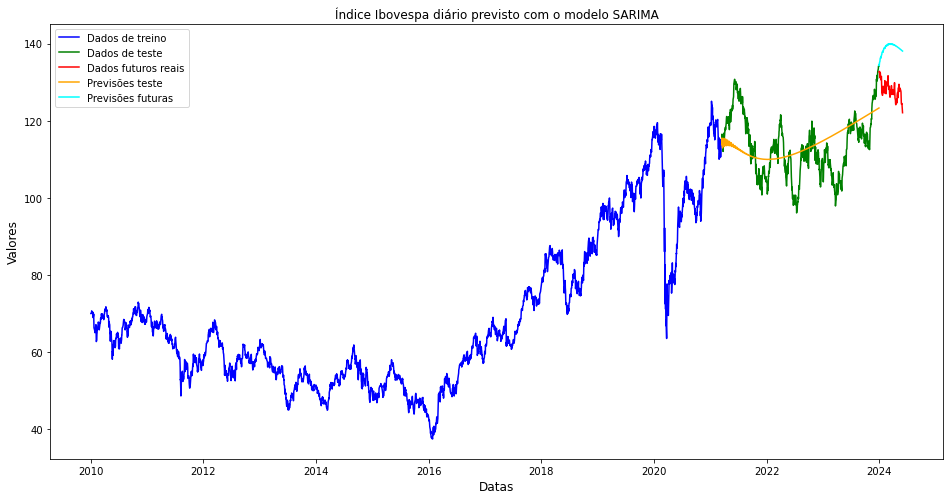

In [446]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo SARIMA')

plt.legend()
plt.show()

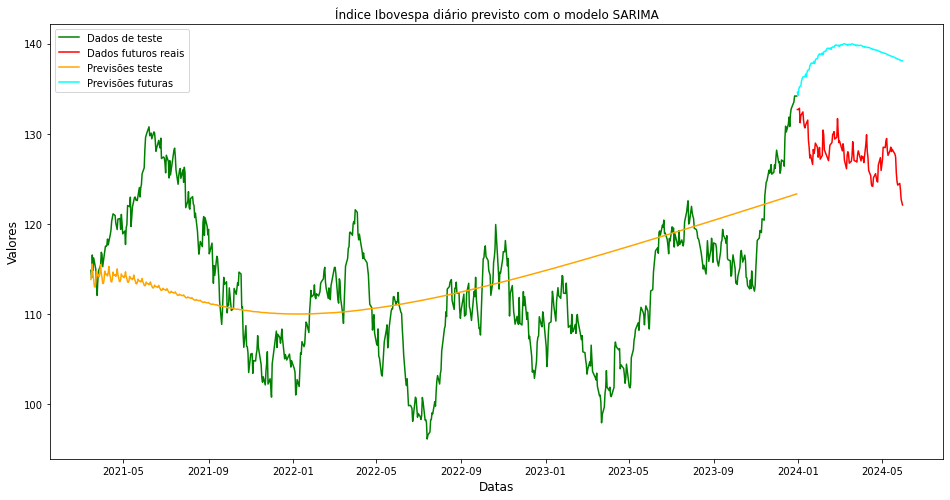

In [447]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo SARIMA')

plt.legend()
plt.show()

In [450]:
data_inicio = pd.to_datetime('2021-03-01').date()
data_fim = pd.to_datetime('2021-04-01').date()

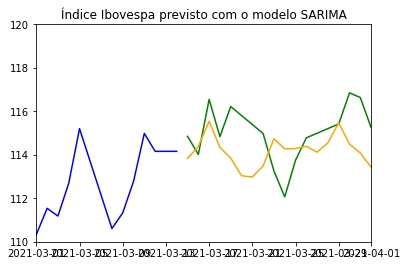

In [452]:
# Exemplo de zoom manual em uma parte específica do gráfico
plt.xlim(data_inicio, data_fim)  # Defina os limites desejados
plt.ylim(110, 120)
# Linha da série temporal
plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados futuros reais')


# Linha das previsões
plt.plot(predicao_teste, label='Previsões testes', color='orange')
plt.plot(predicao_futura, label='Previsões futuras', color='cyan')

#plt.ylabel('Valores', fontsize=12)
#plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

#plt.legend()
plt.show()

# Eliminando dados irregulares da pandemia

In [36]:
treino1  = treino.loc['2016-01-01':'2020-02-01']
treino2 = treino.loc['2020-07-02':]
dados_pand = treino.loc['2020-02-02':'2020-07-01']

In [37]:
# Defina o intervalo de datas
data_inicio = '2020-02-02'
data_fim = '2020-07-01'

# Crie as datas dentro do intervalo
datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Gere valores entre 110 e 120
valores = np.linspace(117.597180, 96.234960, num=len(datas))

# Crie um DataFrame com as datas e valores
dados_pand = pd.DataFrame({'data': datas, 'valor': valores})
dados_pand.index = dados_pand['data']
dados_pand.drop('data', axis=1, inplace=True)


In [38]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])

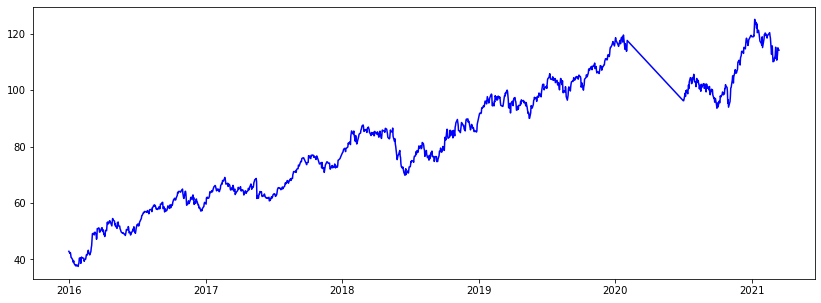

In [39]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Treino')
plt.show()

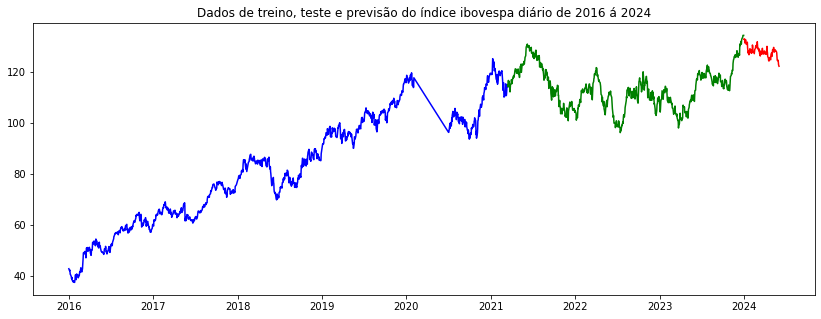

In [40]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Treino')
plt.plot(teste.index, teste['valor'],color='green', label='Teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Previsão')
plt.title('Dados de treino, teste e previsão do índice ibovespa diário de 2016 á 2024')
plt.show()

In [458]:
rmse,mae,mape,model, grid_search_melhor_conf,predicao_teste = grid_search(order_combos,seasonal_order_combos, treino_sem_pand, len(teste), teste, "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 113.58616546167534 , mae-- 113.3133297208619 , mape-- 1.0


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 30.970113834411542 , mae-- 29.953992372605132 , mape-- 0.2608214800077196


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 71.89293518636296 , mae-- 67.8228478560023 , mape-- 0.6068012049990746


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 28.262172735064787 , mae-- 25.297898933908083 , mape-- 0.22873621214022438


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 113.03705322530776 , mae-- 112.5577729793854 , mape-- 0.9934151796790418


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 30.582960235366812 , mae-- 29.502600591809845 , mape-- 0.25684897027620673


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 71.601402164084 , mae-- 67.44184340499642 , mape-- 0.6034404757672249


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 28.238697773821006 , mae-- 25.268081250503545 , mape-- 0.22847047808992954


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.008729420084046 , mae-- 6.468354738165198 , mape-- 0.05711954124986876


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 24.080298591172202 , mae-- 21.547214831592772 , mape-- 0.1943937701645927


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 34.644736490656385 , mae-- 30.3783251519662 , mape-- 0.2727012480422696


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 10.468110179074571 , mae-- 8.906470581258608 , mape-- 0.0810454839970098


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.037632945609486 , mae-- 6.491247858776792 , mape-- 0.05732951095267875


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 25.095050906354274 , mae-- 22.430834142049004 , mape-- 0.2022799398423436


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 34.6475273438551 , mae-- 30.379484547735444 , mape-- 0.272709900817612


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 10.474926313704522 , mae-- 8.90896200127868 , mape-- 0.08106584697534716


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 28.416339079753726 , mae-- 25.1489769999348 , mape-- 0.22619396211911255


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.983240293286104 , mae-- 6.468680869916517 , mape-- 0.05744005601796611


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 16.788111427621082 , mae-- 14.967157920509404 , mape-- 0.13581777615153648


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 25.37403475742296 , mae-- 22.689034775960593 , mape-- 0.20524912185042327


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 28.22401987966242 , mae-- 24.982347017907355 , mape-- 0.22470936934788616


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.938464024130812 , mae-- 6.418535109615143 , mape-- 0.05678152672247386


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 17.07370532564913 , mae-- 15.22485064192348 , mape-- 0.13809933503703156


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 26.408463556854883 , mae-- 23.61555577119959 , mape-- 0.2135980427617396


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.047131559007951 , mae-- 6.498338832709803 , mape-- 0.05738563269415342


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 25.05198123228711 , mae-- 22.392794632678058 , mape-- 0.2019390070321772


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 34.04570041252724 , mae-- 29.871439207809573 , mape-- 0.26817916436300077


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 9.882494049920146 , mae-- 8.284214844236745 , mape-- 0.0752087059040222


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.081026645247055 , mae-- 6.519977613256381 , mape-- 0.05749099307754778


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 25.09694017904717 , mae-- 22.431963542687676 , mape-- 0.20228840912284202


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 34.30231058137321 , mae-- 30.087191932409844 , mape-- 0.27009959410146744


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 9.350061162232672 , mae-- 7.753521900844715 , mape-- 0.07005969312050174


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 113.55137450219563 , mae-- 113.27094017868767 , mape-- 0.999630916246824


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 30.92401235711885 , mae-- 29.905487521216358 , mape-- 0.2603927607109994


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 71.84669370469084 , mae-- 67.75994292420751 , mape-- 0.6062466194852009


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 28.14432389885265 , mae-- 25.187344302210462 , mape-- 0.22774267743407478


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 113.02042227405393 , mae-- 112.53660405784981 , mape-- 0.9932306628053686


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 30.76059876944097 , mae-- 29.687710991590787 , mape-- 0.25849079483382514


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 71.54427381010211 , mae-- 67.36378910348118 , mape-- 0.602752464375055


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 28.123609447063814 , mae-- 25.161772524150845 , mape-- 0.22751463636906163


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.00200773276605 , mae-- 6.4640389049115745 , mape-- 0.05709456720563154


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 24.185438390439128 , mae-- 21.639407455281983 , mape-- 0.19521854102720898


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 34.12760926835209 , mae-- 29.944555450132736 , mape-- 0.26883882447769153


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 11.074489156087457 , mae-- 9.541024724175138 , mape-- 0.08690997119704855


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 7.970826431062762 , mae-- 6.437796850661836 , mape-- 0.05686898014865077


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 25.179522940882016 , mae-- 22.511650228884868 , mape-- 0.20302079332696923


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 34.320301562791265 , mae-- 30.11034259103067 , mape-- 0.27032995549647915


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 10.848152414583856 , mae-- 9.325895018879864 , mape-- 0.08493851964363312


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 27.148837128242583 , mae-- 24.07500881600941 , mape-- 0.21664057011149201


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 8.0229109616087 , mae-- 6.421380104590836 , mape-- 0.055957700783574725


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 22.033424090347932 , mae-- 19.693168388558703 , mape-- 0.17772489466896368


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 25.31290599850881 , mae-- 22.633786738072953 , mape-- 0.2047506575486419


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 28.30066093878338 , mae-- 25.060450410283593 , mape-- 0.22542439073950454


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 9.168562766894139 , mae-- 7.573419696242361 , mape-- 0.0686959198526805


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 12.790256733842753 , mae-- 11.162091833298184 , mape-- 0.10176251504539495


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 26.237213056319924 , mae-- 23.459871850253357 , mape-- 0.21219722917497402


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.9679542253465705 , mae-- 6.433591917675121 , mape-- 0.05681455382844183


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 24.949215479112677 , mae-- 22.311692832746342 , mape-- 0.20122472447658674


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 34.313182376532644 , mae-- 30.10366727729934 , mape-- 0.2702620518442892


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 12.627391043244591 , mae-- 11.063484147866955 , mape-- 0.10084390952545902


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 7.974748970234838 , mae-- 6.4345020090537846 , mape-- 0.05675797880976219


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 25.179155637268515 , mae-- 22.511320761061043 , mape-- 0.20301759792062124


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 34.319048366111765 , mae-- 30.109292109680187 , mape-- 0.2703206475240942


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 10.87094123230842 , mae-- 9.35048719345834 , mape-- 0.08516677631610806


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913521334786574 , mae-- 6.433117405484818 , mape-- 0.05733066633653761


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 24.443467215454287 , mae-- 21.87079020899577 , mape-- 0.19744073950640842


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 36.169034114699286 , mae-- 31.674550061624405 , mape-- 0.2843969413570162


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 13.352108666642449 , mae-- 11.75812154745683 , mape-- 0.10731596153578776


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.913176125465547 , mae-- 6.432729422178484 , mape-- 0.05732565715396735


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.499856003119515 , mae-- 22.790425065440264 , mape-- 0.20564658670803262


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 36.168688912712 , mae-- 31.674252815765406 , mape-- 0.28439421820613653


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 13.351771166204486 , mae-- 11.757814165507108 , mape-- 0.10731310369997532


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 130.09557077743102 , mae-- 112.58712767650839 , mape-- 1.004876088886757


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 188.42693583229413 , mae-- 157.4247546864841 , mape-- 1.3994863653476266


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 206.46738435052958 , mae-- 170.59176859198115 , mape-- 1.514742144354889


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 109.38265821000896 , mae-- 96.9733520839785 , mape-- 0.868741836303767


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 24.327009353630903 , mae-- 21.769366068144677 , mape-- 0.19653220823966774


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 13.105399893435905 , mae-- 11.518434693222444 , mape-- 0.10514946448518446


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 69.63891553151548 , mae-- 53.59059968361353 , mape-- 0.46793860979312224


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 178.3992067594464 , mae-- 133.4713791633904 , mape-- 1.1694415856273637


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.913216530800208 , mae-- 6.43277493807849 , mape-- 0.05732624464958762


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 25.64682104149917 , mae-- 22.91809490970916 , mape-- 0.20678602113231476


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 36.13093207027553 , mae-- 31.642601154640545 , mape-- 0.2841120641001068


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 13.34183394808117 , mae-- 11.748314946867975 , mape-- 0.10722665536823954


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.913363238359159 , mae-- 6.43293930062765 , mape-- 0.05732837001908997


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 25.627831264584866 , mae-- 22.90157902490449 , mape-- 0.20663905164553276


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 36.179740177446746 , mae-- 31.683502035354294 , mape-- 0.2844765657915219


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 13.302756973140513 , mae-- 11.70990943300185 , mape-- 0.10688175057013946


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 43.95536513560066 , mae-- 37.83170937621765 , mape-- 0.33125347808219235


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 30.47281954704404 , mae-- 27.279536340234838 , mape-- 0.2383751541906399


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 94.56705740523235 , mae-- 75.81236099718797 , mape-- 0.6651436111960025


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 161.38433751827682 , mae-- 124.5164757703496 , mape-- 1.0925618958563383


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 24.327191151665744 , mae-- 21.7695250040935 , mape-- 0.1965336219813173


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 13.106850495087688 , mae-- 11.519851660547761 , mape-- 0.10516225731576018


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 93.82838645701271 , mae-- 74.10113598800294 , mape-- 0.6496049051543167


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 192.4793105864708 , mae-- 146.38891446346378 , mape-- 1.2842961365167778


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913516454771308 , mae-- 6.433112091696045 , mape-- 0.05733059689411317


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 24.528248515293363 , mae-- 21.944762287019454 , mape-- 0.19810066971473914


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 35.035119088233714 , mae-- 30.724232799629025 , mape-- 0.27593501793988123


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 12.445207272656962 , mae-- 10.878065991476266 , mape-- 0.0993444532282637


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.913076418059392 , mae-- 6.43261699366646 , mape-- 0.057324206114960946


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.794176847523076 , mae-- 23.046052169218374 , mape-- 0.20792754961054205


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 35.03477840310616 , mae-- 30.723938995392075 , mape-- 0.27593232633514847


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 12.444887757006134 , mae-- 10.877778045441381 , mape-- 0.09934175453888561


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 128.34776034374565 , mae-- 111.06704812255511 , mape-- 0.9913731838902613


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 193.59847939107473 , mae-- 161.1710866888552 , mape-- 1.4323322787203183


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 201.50991930908674 , mae-- 166.67064016618656 , mape-- 1.480143262827065


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 109.83254413204868 , mae-- 97.17403136950855 , mape-- 0.8703081163754337


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 24.403824014763188 , mae-- 21.83644278519298 , mape-- 0.1971304389070855


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 12.881286577741445 , mae-- 11.298692149441813 , mape-- 0.1031655351944543


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 70.78156470985395 , mae-- 54.44090740781273 , mape-- 0.47541491649521445


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 173.16188800057233 , mae-- 129.63881321539046 , mape-- 1.1357942471332552


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.9128009895102425 , mae-- 6.4323060188613566 , mape-- 0.05732019139302121


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 25.648446141924257 , mae-- 22.919529855584045 , mape-- 0.20679838346371207


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 34.99831910894714 , mae-- 30.69332424136155 , mape-- 0.2756594089700534


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 12.436370337060048 , mae-- 10.86973074437099 , mape-- 0.09926791006232032


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.91307818151078 , mae-- 6.432618889446584 , mape-- 0.057324231068733376


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 25.800137075731723 , mae-- 23.051224144600734 , mape-- 0.20797373076723233


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 35.1411256092605 , mae-- 30.813127044726414 , mape-- 0.2767264474054663


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 12.466598314494096 , mae-- 10.898456006213951 , mape-- 0.0995307607681826


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 44.06609705532001 , mae-- 37.929721780563916 , mape-- 0.3321240867776101


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 30.699022894075277 , mae-- 27.47087487428384 , mape-- 0.24006722697737337


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 95.16287326306423 , mae-- 76.25399144395189 , mape-- 0.6690249770949186


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 158.0605524924537 , mae-- 122.10560142914703 , mape-- 1.071410680981025


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 24.40409486280247 , mae-- 21.83667938830792 , mape-- 0.1971325453347797


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 12.96959530176957 , mae-- 11.38517822000148 , mape-- 0.10394723905048439


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 94.68332268916545 , mae-- 74.72758457942113 , mape-- 0.6551077966643375


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 187.54791428785558 , mae-- 142.7794491739771 , mape-- 1.2526081424147846


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 29.382398892469045 , mae-- 25.997224626670512 , mape-- 0.2339149350016718


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 8.333998968601026 , mae-- 6.801533583761114 , mape-- 0.06128584481886058


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.5028891094479 , mae-- 21.01539919536196 , mape-- 0.18968408948111262


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 25.693903609667558 , mae-- 23.054083367428166 , mape-- 0.20834379301489997


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 30.20101463721401 , mae-- 26.68714578379151 , mape-- 0.24004935982039874


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 8.374027224032854 , mae-- 6.837770160202244 , mape-- 0.06164937520825955


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 22.76771639593576 , mae-- 15.767410127067652 , mape-- 0.13520284380500672


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 19.977216824670847 , mae-- 17.928646529301524 , mape-- 0.1622245728942476


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.286870590477648 , mae-- 6.751065456067361 , mape-- 0.060787743840109924


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 27.424020622839095 , mae-- 24.454200464171297 , mape-- 0.22066664029569227


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 38.201094942508924 , mae-- 33.417420537446965 , mape-- 0.30008706116199624


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 11.154923249595445 , mae-- 9.513838665463231 , mape-- 0.08696361617448828


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.340648577830647 , mae-- 6.807039453517692 , mape-- 0.06133981897853103


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 25.592375150539368 , mae-- 22.96410587800057 , mape-- 0.20752999043440437


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 38.513760084136045 , mae-- 33.687124581701596 , mape-- 0.3025149995666448


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 11.26411202161483 , mae-- 9.614575674759655 , mape-- 0.08791367134898576


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 30.00454859554742 , mae-- 26.52170794453522 , mape-- 0.23857810340745206


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.805419935520404 , mae-- 6.297991604802547 , mape-- 0.05562575115645836


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 67.26278103282363 , mae-- 60.65113450177724 , mape-- 0.5443808672875925


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 30.74234573751728 , mae-- 27.484657235941913 , mape-- 0.24836241896052563


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 30.03587870399371 , mae-- 26.548110754200376 , mape-- 0.2388130846380008


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.806904448187755 , mae-- 6.276033570433178 , mape-- 0.05518837760075883


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 67.04217357587186 , mae-- 60.37958738246483 , mape-- 0.5419850141396568


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 21.695511722653226 , mae-- 19.483762376235102 , mape-- 0.17619274220236164


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.057498575492133 , mae-- 6.446426551966511 , mape-- 0.05624399467952888


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 23.863892924225805 , mae-- 21.380444162095262 , mape-- 0.19256085165804201


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 39.144736739239846 , mae-- 34.23318667474042 , mape-- 0.3074348051957784


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 10.80979490343261 , mae-- 9.103725858438597 , mape-- 0.08320451917278938


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.341247307974603 , mae-- 6.8075813075866805 , mape-- 0.06134530287869482


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 24.847442043766343 , mae-- 22.30246239986089 , mape-- 0.20158712498105316


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 37.93740858674766 , mae-- 33.20254098772094 , mape-- 0.29820028912868374


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 10.256547745645724 , mae-- 8.564622394117054 , mape-- 0.07808914903540944


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 29.160231672395575 , mae-- 25.809679381559402 , mape-- 0.23224663596090095


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 8.207700579590783 , mae-- 6.6890524508347955 , mape-- 0.060131764276771624


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 24.085370010568873 , mae-- 21.51391433488964 , mape-- 0.19410524060862294


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 25.670799752063978 , mae-- 23.032857667103208 , mape-- 0.20815725560981818


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 29.82606322817853 , mae-- 26.371299219558733 , mape-- 0.2372401996516183


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 8.085412277276559 , mae-- 6.586515218672051 , mape-- 0.059038186871259765


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 20.627067055671905 , mae-- 14.42162500392543 , mape-- 0.12360316804681482


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 22.783352316855463 , mae-- 20.44819071742086 , mape-- 0.18487455222059998


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.191702231938393 , mae-- 6.663332422105858 , mape-- 0.05983001158659748


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 26.79388241137638 , mae-- 23.90690469014638 , mape-- 0.2157299289256291


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 35.31421711461935 , mae-- 30.979486240129525 , mape-- 0.27833367388053604


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 10.332193109647847 , mae-- 8.687750164614249 , mape-- 0.0792362329546185


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.105775495134623 , mae-- 6.603131133697911 , mape-- 0.059218007783624065


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 25.72817460275488 , mae-- 23.084234813693854 , mape-- 0.20862322153392823


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 35.43315966695733 , mae-- 31.084489614116524 , mape-- 0.2792923105275942


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 10.41471429739177 , mae-- 8.765279146183222 , mape-- 0.07997526905204087


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 29.77137473528886 , mae-- 26.32519190857814 , mape-- 0.23683002667543615


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.924306728115443 , mae-- 6.321013439572703 , mape-- 0.055129407933451176


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 9.774018549059019 , mae-- 8.262780727582182 , mape-- 0.07400268660342124


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 24.057212317039756 , mae-- 21.596377822349865 , mape-- 0.19524475709415443


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 30.329350233211184 , mae-- 26.79847444259942 , mape-- 0.24106223057536172


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.802309687133835 , mae-- 6.278133891687146 , mape-- 0.055267008777048376


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 98.3852255367006 , mae-- 69.54868458763237 , mape-- 0.6044194103291085


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 21.999832134668598 , mae-- 19.754690989248306 , mape-- 0.17861242585911777


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 8.028621845129177 , mae-- 6.428885024132241 , mape-- 0.05617050847812864


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 23.98037055394067 , mae-- 21.484310042690662 , mape-- 0.19353413871211078


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 37.637808474681165 , mae-- 32.949885476464424 , mape-- 0.2959459148879695


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 10.78084406718763 , mae-- 9.112890580203045 , mape-- 0.08324760240863309


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.10622466871739 , mae-- 6.603508011486144 , mape-- 0.05922205597413108


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 25.175861414174026 , mae-- 22.591883271593034 , mape-- 0.2042074294812039


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 37.73233827744498 , mae-- 33.01602365368464 , mape-- 0.29648132339074246


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 10.61656665107997 , mae-- 8.96344045946293 , mape-- 0.08182181105222686


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913521334786574 , mae-- 6.433117405484818 , mape-- 0.05733066633653761


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 24.44772557683516 , mae-- 21.874523831545872 , mape-- 0.19747381560634675


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 36.16736467949927 , mae-- 31.67311955377192 , mape-- 0.28438385548593215


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 13.116760623193835 , mae-- 11.528114198567419 , mape-- 0.10524231350089457


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.913031026059519 , mae-- 6.432565611925524 , mape-- 0.057323543789768824


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.491748776506128 , mae-- 22.783399583873504 , mape-- 0.20558354282259533


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 36.1772622980354 , mae-- 31.68139959832864 , mape-- 0.28445750601094305


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 13.116432278593443 , mae-- 11.527813798123187 , mape-- 0.10523951825031662


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 128.42409884061192 , mae-- 111.13346012589751 , mape-- 0.9919631221906011


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 186.322869401593 , mae-- 155.63985200834887 , mape-- 1.3836580873162876


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 203.58344187549343 , mae-- 168.22344399470106 , mape-- 1.4937889944609215


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 129.32066990802758 , mae-- 112.3663077160808 , mape-- 1.003642902164817


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 24.40995359292818 , mae-- 21.84179441043113 , mape-- 0.19717816419522116


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 12.891073015184599 , mae-- 11.308237117122822 , mape-- 0.1032519418378006


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 71.59257613136708 , mae-- 55.050695711812914 , mape-- 0.4807794806763008


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 154.00331885179648 , mae-- 115.5946444154578 , mape-- 1.0124686287454903


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.9130850786640154 , mae-- 6.432626648924445 , mape-- 0.05732433133044251


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 25.48579211727938 , mae-- 22.77821885280757 , mape-- 0.2055374231048247


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 36.13952910224058 , mae-- 31.649768749452594 , mape-- 0.28417554501073217


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 13.106881239828368 , mae-- 11.518652564639265 , mape-- 0.10515605404447491


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.913163685421067 , mae-- 6.432714390431925 , mape-- 0.057325468442904294


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 25.573138101231944 , mae-- 22.854097136676998 , mape-- 0.20621484107338878


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 36.161014742864104 , mae-- 31.667789230735977 , mape-- 0.28433631229711964


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 13.079428917334303 , mae-- 11.491430166546737 , mape-- 0.10491174042847222


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 44.05002373323963 , mae-- 37.91549396974144 , mape-- 0.331997706246285


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 28.662607401141457 , mae-- 25.835999380350845 , mape-- 0.22567620210061878


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 95.54200547106035 , mae-- 76.53649582984282 , mape-- 0.6715086831091754


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 146.16914020974806 , mae-- 113.45900875936117 , mape-- 0.9955337894403784


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 24.40941767145261 , mae-- 21.841326789736858 , mape-- 0.19717399045669762


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 12.94293290600344 , mae-- 11.358951759386606 , mape-- 0.1037104482613651


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 95.38293235969849 , mae-- 75.25142114756684 , mape-- 0.6597152017291203


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 170.1345424104622 , mae-- 130.04569028741375 , mape-- 1.1408122067235862


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.913514519630244 , mae-- 6.43310998012981 , mape-- 0.05733056932057091


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 24.528550883067744 , mae-- 21.94502765411029 , mape-- 0.19810301489080145


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 35.862131623658 , mae-- 31.41746439779223 , mape-- 0.28210749652620154


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 12.555064410850536 , mae-- 10.98255247368532 , mape-- 0.10029942975625515


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 7.912995739678044 , mae-- 6.4325259911360435 , mape-- 0.057323031304980274


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 25.791790878990067 , mae-- 23.04398447804367 , mape-- 0.20790902609927966


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 35.866359970588 , mae-- 31.42099861827494 , mape-- 0.2821388901791163


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 12.554743586684591 , mae-- 10.982264213461836 , mape-- 0.10029672947406276


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 128.50298238695316 , mae-- 111.2019214874112 , mape-- 0.9925712748700254


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 193.94344894718148 , mae-- 161.45063152135145 , mape-- 1.434803692361873


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 202.47398374394098 , mae-- 167.36549933999234 , mape-- 1.4862311426719987


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 99.1006041498887 , mae-- 88.59349176876876 , mape-- 0.7950071180756614


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 24.414614903761695 , mae-- 21.845864671560225 , mape-- 0.19721445360257572


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 12.836958048748716 , mae-- 11.25524028549035 , mape-- 0.10277270646688769


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 74.91820380397526 , mae-- 57.550760912777214 , mape-- 0.5027737204849201


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 191.25820785149745 , mae-- 142.97642174787768 , mape-- 1.2529715616443557


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 7.913146176294427 , mae-- 6.432695728805879 , mape-- 0.05732522196397277


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 25.48526718808751 , mae-- 22.777762220270063 , mape-- 0.2055333639074254


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 35.8354428768836 , mae-- 31.395064423700976 , mape-- 0.28190765125558886


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 12.546059648523142 , mae-- 10.974074668326692 , mape-- 0.10022162289757103


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 7.913004814728206 , mae-- 6.432536129909331 , mape-- 0.057323162720234216


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 25.81067360971392 , mae-- 23.06036561918471 , mape-- 0.208055362878043


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 35.76289012040963 , mae-- 31.33430669631833 , mape-- 0.2813669803753191


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 12.576943176996297 , mae-- 11.003388939274577 , mape-- 0.10048970864983679


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 44.10242360315364 , mae-- 37.96184594361674 , mape-- 0.332409433302174


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 28.821464560790197 , mae-- 25.96884055551837 , mape-- 0.2268491789913534


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 97.45392220196518 , mae-- 77.9617291133814 , mape-- 0.6840394358071388


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 168.9596972777447 , mae-- 130.06513752499202 , mape-- 1.1412897823974397


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 24.414722790588637 , mae-- 21.845959129703928 , mape-- 0.1972152906581915


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 12.811312212006376 , mae-- 11.230024728830486 , mape-- 0.10254479515769253


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 98.342670980859 , mae-- 77.46741375182246 , mape-- 0.6792060852275887


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 203.87741586179055 , mae-- 154.77913625525318 , mape-- 1.3580083096876845
A melhor configuração para essa série temporal é:[(1, 0, 1), (1, 0, 1, 12), 'c']
rmse:7.802309687133835
mae:6.278133891687146
mape:0.055267008777048376


In [44]:
treino_concat = pd.concat([treino_sem_pand, teste])
teste_concat = pd.concat([previsao])

In [461]:
rmse_pred,mae_pred,mape_pred,melhor_model,predicao_futura = seasonal_arima_model(teste_concat,treino_concat,grid_search_melhor_conf[0],grid_search_melhor_conf[1], grid_search_melhor_conf[2],len(teste_concat),"SARIMA")

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [45]:
auto_arima_config

[(1, 1, 0), (0, 0, 0, 12), 'n']

In [462]:
print(rmse_pred)
print(mae_pred)
print(mape_pred)

5.0613858860126655
4.7906961689973535
0.037659856372274335


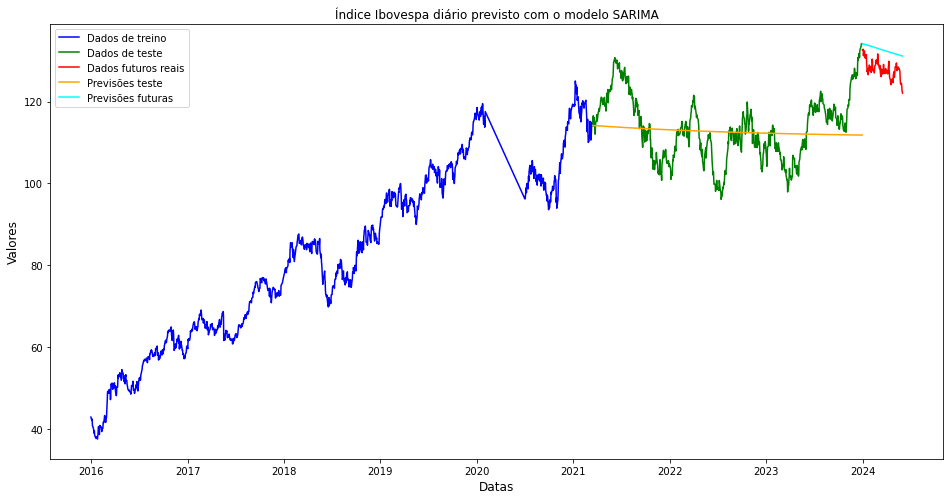

In [463]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo SARIMA')

plt.legend()
plt.show()

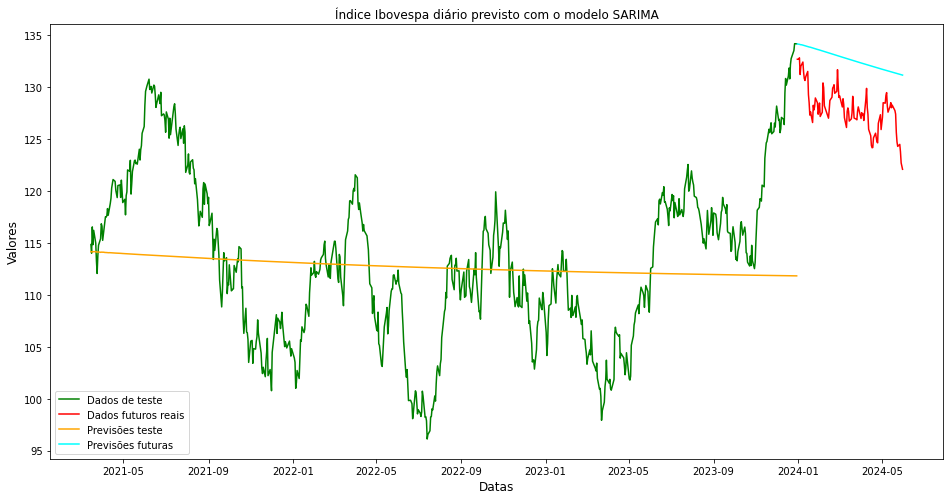

In [464]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de teste')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo SARIMA')

plt.legend()
plt.show()

In [354]:
rmse = np.sqrt(mean_squared_error(teste_concat2, previsto2))
mae = mean_absolute_error(teste_concat2, previsto2)
mape = mean_absolute_percentage_error(teste_concat2, previsto2)

print(rmse)
print(mae)
print(mape)

9.22270606139885
7.377675607322255
0.06297644941879635


# Série com dados mensais

In [19]:
treino_mensal = treino.copy()
teste_mensal = teste.copy()
previsao_mensal = previsao.copy()

In [20]:
treino_mensal['data'] = treino_mensal.index
teste_mensal['data'] = teste_mensal.index
previsao_mensal['data'] = previsao_mensal.index

In [21]:
treino_mensal = treino_mensal.resample('M', on='data').mean()
teste_mensal = teste_mensal.resample('M', on='data').mean()
previsao_mensal = previsao_mensal.resample('M', on='data').mean()

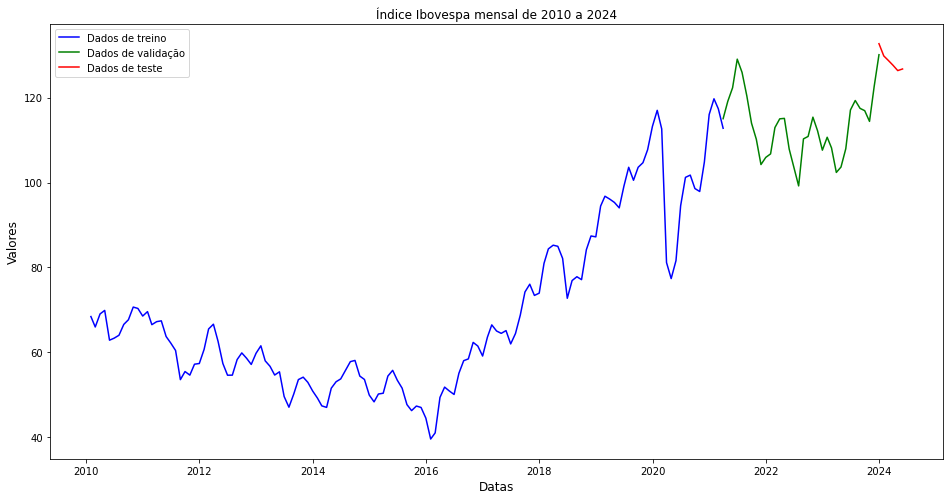

In [22]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal,color='blue', label='Dados de treino')
plt.plot(teste_mensal,color='green', label='Dados de validação')
plt.plot(previsao_mensal,color='red', label='Dados de teste')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal de 2010 a 2024')

plt.legend()
plt.show()

In [488]:
rmse,mae,mape,model, grid_search_melhor_conf, predicao_teste = grid_search(order_combos,seasonal_order_combos, treino_mensal, len(teste_mensal), teste_mensal, "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}\nrmse:{rmse}\nmae:{mae}\nmape:{mape}")

order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 113.58730295686979 , mae-- 113.34462340890025 , mape-- 1.0
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 44.97646343096851 , mae-- 44.36001043109595 , mape-- 0.38879540728146994
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 19.795449037341193 , mae-- 17.724317417226466 , mape-- 0.1600905390604551
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 17.489557475126052 , mae-- 15.388735736194656 , mape-- 0.13201083633477695
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 100.26311646824813 , mae-- 97.38959853478109 , mape-- 0.8597575786511893
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 41.21835136784864 , mae-- 39.357471427612595 , mape-- 0.34395799665171395
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 19.97393519206508 , mae-- 18.858958160908468 , mape-- 0.16802658229051085
order--  (0, 0, 0) , seasona

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 31.17357914455787 , mae-- 27.656408841984966 , mape-- 0.2485875217248393
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 21.224113601814746 , mae-- 18.124979731887056 , mape-- 0.15874986287156487
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 16.701260119336272 , mae-- 13.551169834874388 , mape-- 0.11923600636267417
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 19.098461903354426 , mae-- 17.59664689024678 , mape-- 0.1559416308196063
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 34.64545700834623 , mae-- 30.072164946391993 , mape-- 0.2694481495641198
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 20.763874793654495 , mae-- 17.60707087002099 , mape-- 0.15452604825814661
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 15.96659390834512 , mae-- 14.762803190711987 , mape-- 0.1312185957250117
order--  (0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 42.149165175813344 , mae-- 37.00897495623486 , mape-- 0.3320264540054719
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 14.285813085589133 , mae-- 11.550557040746575 , mape-- 0.10167255945486502
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 14.24485946974362 , mae-- 11.884774410848674 , mape-- 0.10335391165798483
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 19.11751281942452 , mae-- 17.619538799980646 , mape-- 0.15763168556806048
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 14.26415050700359 , mae-- 13.02519076591428 , mape-- 0.11636084473337333
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 14.243891545259027 , mae-- 11.45764309998777 , mape-- 0.10090169611806998
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 15.552632310286807 , mae-- 13.147722592894498 , mape-- 0.11370402843911563
order--  (0

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 28.900622470812472 , mae-- 25.688018577744234 , mape-- 0.23095012905143777
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 17.101326567778905 , mae-- 14.598380677270809 , mape-- 0.1268022504347635
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 13.586005765624346 , mae-- 10.942010732511061 , mape-- 0.09625266726472585
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 19.68946478199131 , mae-- 17.913263434751865 , mape-- 0.15967822648969468
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 35.55285429748191 , mae-- 30.73918228433523 , mape-- 0.2755903231022075
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 17.1544608642102 , mae-- 14.63104827490531 , mape-- 0.12697602172082045
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 14.546172628268254 , mae-- 13.127483304778844 , mape-- 0.11694674119473046
order--  (0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 42.11509440663406 , mae-- 36.97664603353919 , mape-- 0.33173704756566597
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.442328066313387 , mae-- 6.0314188113128235 , mape-- 0.052941393032185355
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 10.04453728538787 , mae-- 8.718763737912314 , mape-- 0.07893374632220841
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 22.45632002582112 , mae-- 20.07050308789367 , mape-- 0.18056099635170633
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 30.49269603654727 , mae-- 26.825218404112135 , mape-- 0.2407084982017017
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 11.34433002675544 , mae-- 9.962677100929321 , mape-- 0.09071144355861564
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 17.34621852046494 , mae-- 15.676446634145222 , mape-- 0.1422819662874753
order--  (0, 1, 

order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 51.54530774787482 , mae-- 44.52260325021453 , mape-- 0.3980775976213106
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 48.69870381958565 , mae-- 42.16034544978814 , mape-- 0.37722287753124606
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 27.57313371744577 , mae-- 24.43892379863919 , mape-- 0.21998408018657434
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 39.21956521170189 , mae-- 34.31086382450811 , mape-- 0.30767985422489047
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 45.384696972173295 , mae-- 39.4544018078386 , mape-- 0.3532942704660227
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 39.141758823371525 , mae-- 34.246871325994206 , mape-- 0.30711240689577707
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 11.705743578935046 , mae-- 10.335877830777632 , mape-- 0.09364332841290791
order--  (1, 0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 14.536736419733863 , mae-- 13.092022094373974 , mape-- 0.1186072116551534
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 13.38858591078442 , mae-- 11.454603276456162 , mape-- 0.10400439652845468
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 18.169962620000796 , mae-- 15.862216848579594 , mape-- 0.1432920677213535
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 27.13095126366837 , mae-- 23.42744425369344 , mape-- 0.21067480831146326
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 37.09875579073557 , mae-- 31.96574512339022 , mape-- 0.2867099863974974
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 12.38879920515927 , mae-- 10.638855178235081 , mape-- 0.09672638998335885
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 16.309862014105864 , mae-- 14.65975725780514 , mape-- 0.1323805997473221
order--  (1, 0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 39.98166083997088 , mae-- 35.12365227772738 , mape-- 0.3148336681087662
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 8.899588416872572 , mae-- 7.415621868566585 , mape-- 0.06678511320502575
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 14.803671155627153 , mae-- 12.340418303427823 , mape-- 0.10562755647164866
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 20.860300106189484 , mae-- 18.79227005532718 , mape-- 0.1690095653754713
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 7.483879010442215 , mae-- 5.907471555053302 , mape-- 0.05208489515422994
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 17.004429566396436 , mae-- 15.298183064101936 , mape-- 0.1389309946075248
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 10.599693670844623 , mae-- 8.114891509797804 , mape-- 0.0695421231049147
order--  (1, 0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 10.336209008800179 , mae-- 9.007749396226838 , mape-- 0.08155754707238982
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 17.25558395045428 , mae-- 15.563823170620019 , mape-- 0.1412801374669993
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 10.512963397969623 , mae-- 8.011060555507422 , mape-- 0.06866181352200776
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 21.34657631794826 , mae-- 19.19269651362707 , mape-- 0.17295482734365536


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 11.73079493014884 , mae-- 10.284083154466266 , mape-- 0.09303838539153403
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 10.51359010129584 , mae-- 8.179270023505433 , mape-- 0.07478014472678546
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 15.608161243947706 , mae-- 13.495964842243737 , mape-- 0.12227971300297599
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 26.07771707267647 , mae-- 22.246059385402493 , mape-- 0.20037116446340328
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 38.147853784281466 , mae-- 32.768453348715454 , mape-- 0.29402823984909177
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.265174411481695 , mae-- 6.762276437793465 , mape-- 0.06066524626097151
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 13.55331128296402 , mae-- 11.913894598232941 , mape-- 0.1076868987747307
order--  (1,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 39.941527260683195 , mae-- 35.063964889400935 , mape-- 0.3143693044660062
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.793319152017571 , mae-- 6.193779830544332 , mape-- 0.05351383674958426
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 9.014640131752262 , mae-- 7.516216623689279 , mape-- 0.06765663805034967
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 19.87991059624778 , mae-- 17.88836763553333 , mape-- 0.16069847070398866
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 26.15970365709653 , mae-- 23.226787085278254 , mape-- 0.20823658537624312
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 10.964335911941635 , mae-- 9.567216186954706 , mape-- 0.08714582018882576
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 17.20888181771177 , mae-- 15.503321507896237 , mape-- 0.14075472948200748
order--  (1, 1

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 40.60554531209789 , mae-- 35.50678329822521 , mape-- 0.31855613240989156
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 11.436311709173419 , mae-- 9.982199898650668 , mape-- 0.09103670095587786
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 17.9066598979605 , mae-- 16.11479092419965 , mape-- 0.1462840386281257
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 31.283617635363836 , mae-- 27.798249072137086 , mape-- 0.2501965299809214
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 41.085391696147184 , mae-- 35.96583845438925 , mape-- 0.32274200800187647
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 36.430879292312106 , mae-- 31.78785754908282 , mape-- 0.2855367634733928
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 42.52303515927731 , mae-- 37.00962497546965 , mape-- 0.3317030680002911


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 50.46188239728763 , mae-- 43.66448883760602 , mape-- 0.3904829028154677
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 57.27217479273842 , mae-- 49.289154690594415 , mape-- 0.44013795999391503
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 28.70985796116473 , mae-- 25.41719686566065 , mape-- 0.22875700489176976
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 37.34863780949128 , mae-- 32.88253660053918 , mape-- 0.29504914359378615
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 45.651317010294854 , mae-- 39.688379191446224 , mape-- 0.35539894093591307
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 42.99214786359411 , mae-- 37.418380816809375 , mape-- 0.3352928138211297
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 7.649663159033592 , mae-- 6.149391855423478 , mape-- 0.05338284466919836
order--  (1, 1, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 39.60129136510235 , mae-- 34.62606165103744 , mape-- 0.31046443391964784
A melhor configuração para essa série temporal é:[(1, 0, 1), (0, 0, 0, 12), 'ct']
rmse:7.483879010442215
mae:5.907471555053302
mape:0.05208489515422994


In [492]:
treino_concat_mensal = pd.concat([treino_mensal, teste_mensal])
teste_concat_mensal = pd.concat([previsao_mensal])

In [497]:
treino_concat_mensal.index.freq = 'M'
#teste_concat_mensal.index.freq = 'M'

ValueError: Inferred frequency None from passed values does not conform to passed frequency M

In [502]:
rmse_pred,mae_pred,mape_pred,melhor_model,predicao_futura = seasonal_arima_model(teste_concat_mensal,treino_concat_mensal,grid_search_melhor_conf[0],grid_search_melhor_conf[1], grid_search_melhor_conf[2],len(teste_concat_mensal),"SARIMA")

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

In [508]:
predicao_futura.index = previsao_mensal.index

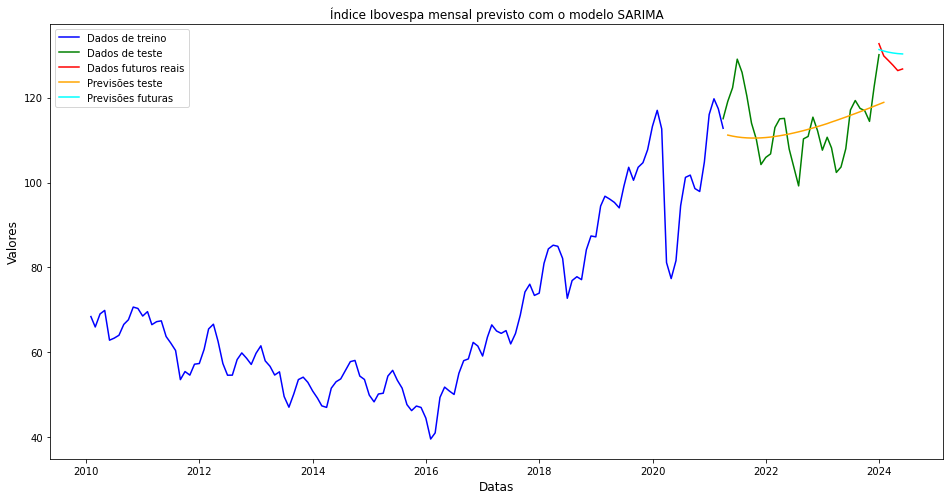

In [513]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo SARIMA')

plt.legend()
plt.show()

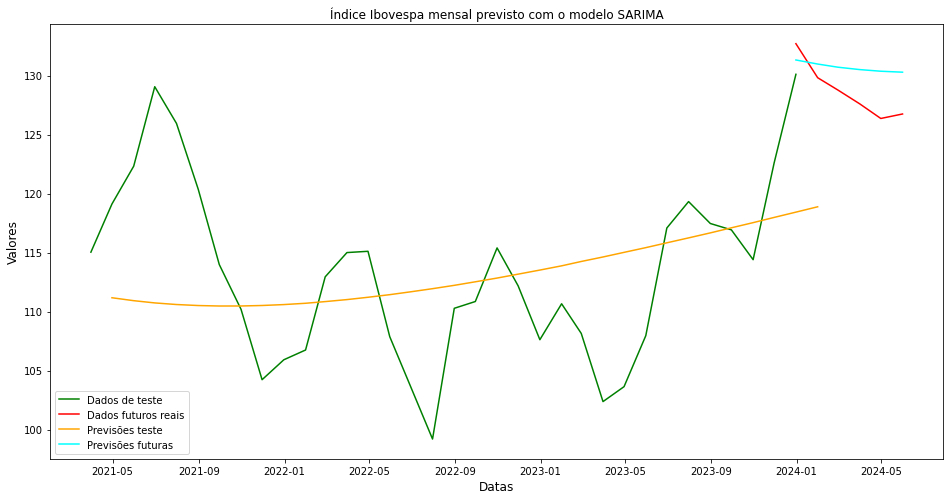

In [512]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')
plt.plot(predicao_teste,color='orange', label='Previsões teste')
plt.plot(predicao_futura,color='cyan', label='Previsões futuras')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo SARIMA')

plt.legend()
plt.show()

In [516]:
rmse = np.sqrt(mean_squared_error(previsao_mensal, predicao_futura))
mae = mean_absolute_error(previsao_mensal, predicao_futura)
mape = mean_absolute_percentage_error(previsao_mensal, predicao_futura)

print(rmse)
print(mae)
print(mape)

2.707599921543015
2.487148618873031
0.01945639582316012


In [7]:
df = pd.concat([treino, teste, previsao])

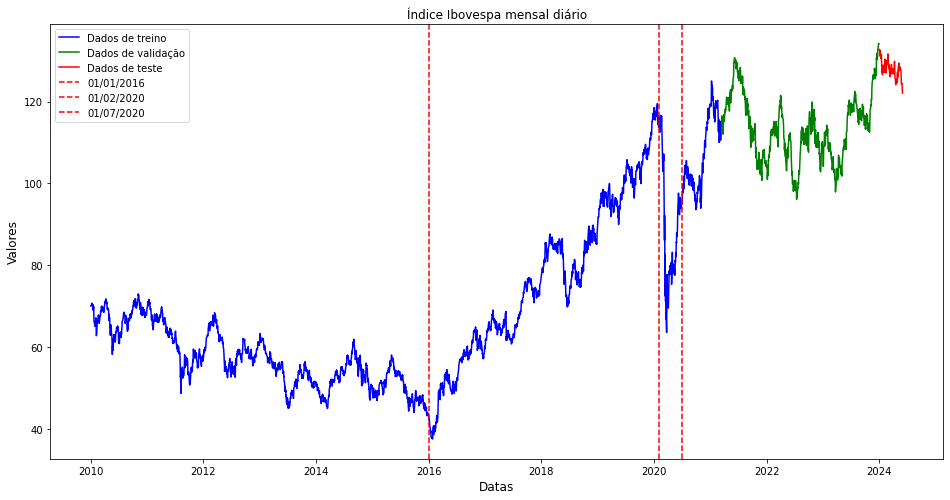

In [11]:


plt.figure(figsize=(16, 8))
#plt.plot(df['data'], df['valor'], label='Valor')

plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')

# Adicione linhas verticais tracejadas vermelhas
plt.axvline(pd.Timestamp('2016-01-01'), color='r', linestyle='--', label='01/01/2016')
plt.axvline(pd.Timestamp('2020-02-01'), color='r', linestyle='--', label='01/02/2020')
plt.axvline(pd.Timestamp('2020-07-01'), color='r', linestyle='--', label='01/07/2020')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal diário')
plt.legend()
plt.show()






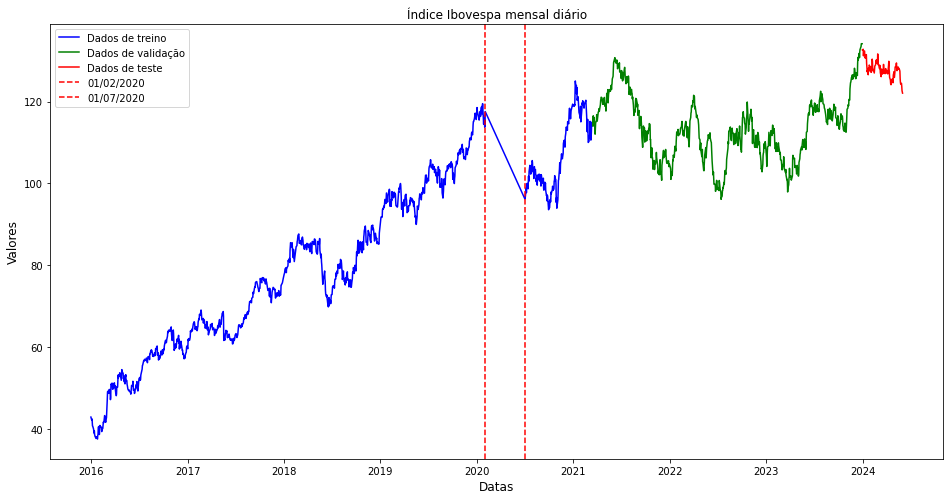

In [17]:
plt.figure(figsize=(16, 8))
#plt.plot(df['data'], df['valor'], label='Valor')

plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')

# Adicione linhas verticais tracejadas vermelhas
plt.axvline(pd.Timestamp('2020-02-01'), color='r', linestyle='--', label='01/02/2020')
plt.axvline(pd.Timestamp('2020-07-01'), color='r', linestyle='--', label='01/07/2020')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal diário')
plt.legend()
plt.show()


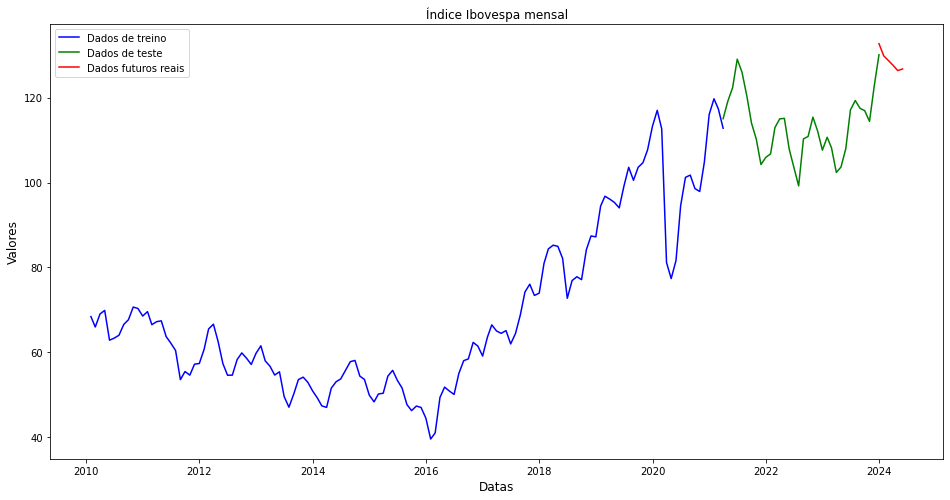

In [37]:
plt.figure(figsize=(16, 8))
#plt.plot(df['data'], df['valor'], label='Valor')

plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de validação')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados de teste')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal')
plt.legend()
plt.show()